# Signal Conversion Lab1 - Sar ADC

## General Functions

In [2]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt  
from numba.typed import List
from numba import njit, prange

Blue    = (       0, 101/255, 189/255 )
Green   = (  52/255, 129/255,  65/255 )
Orange  = ( 241/255,  89/255,  41/255 )

#import datetime

TYPE = np.float64

def num2bin(n,n_bits):
    
    tmp = [ int(i) for i in bin(n)[2:] ]
    if len(tmp) < n_bits:
        code = np.append( [ int(0) for _ in range( int(n_bits) - len(tmp)  ) ],tmp  )
    else:
        code = np.asarray(tmp,dtype=int)
    
    return np.flip(code)


## DAC

$$V_x^{\phi_{n+1}} = V_x^{\phi_n}+V_{r}\frac{ C_{B} {\Delta}C_{Li} + C_{B} {\Delta}C_{Mi} + S_{LC} {\Delta}C_{Mi}}{C_{B}\left( S_{LC} + S_{MC}\right) + S_{LC} S_{MC}}$$


$~$
Where:

$\displaystyle S_{LC} = C_{0'} + \sum_{i=0}^{\text{bits LSB}}C_i$

$\displaystyle S_{MC} = C_{M0} + \sum_{i=0}^{\text{bits MSB}}(C_{ai}+C_{bi})$

#TODO
$\Delta C_{Li} = $ 

$\Delta C_{Mi} = $ 

In [3]:
@njit(nopython=True,fastmath=True)
def dac_bit_weight(Vr,C_ai, C_bi,C_M0, C_Li,C_B,C_B0l,n_bits=-1):

    C_abi = C_ai + C_bi
    S_LC  = C_Li.sum() + C_B0l 
    S_MC  = C_abi.sum() + C_M0

    # First calculate constant values
    slope = Vr/( C_B*( S_MC + S_LC ) + S_LC*S_MC )

    if n_bits == -1:
        n_bits = C_ai.size + C_Li.size + 1
    
    tf_Li = np.column_stack((
        np.zeros_like(C_Li),                # b=0 always 0
        slope * C_B * C_Li                  # b=1 = slope*C_B*c
    ))

    # 2) Row for C_M0
    tf_M0 = np.array([[
        0, 
        slope * (S_LC + C_B) * C_M0
    ]], dtype=TYPE)

    # 3) Rows for C_ai/C_bi pairs
    #    b=0 = –slope*(S_LC + C_B)*C_bi
    #    b=1 =  slope*(S_LC + C_B)*C_ai
    factor = slope * (S_LC + C_B)
    tf_ab  = np.column_stack((
        -factor * C_bi,
         factor * C_ai
    ))
    
    tf = np.vstack((tf_Li, tf_M0, tf_ab))
    
    return tf
    '''
    S_LC_PLUS_C_B = S_LC + C_B
    
    tf = np.empty(shape=(n_bits,2),dtype=TYPE)
    i  = 0
    for c in C_Li:
        tf[i][0] = 0
        tf[i][1] = slope*C_B*c
        i += 1
    
    tf[i][0] =  0
    tf[i][1] = slope*S_LC_PLUS_C_B*C_M0 
    
    for j in range(len( C_ai )):
        #tf[pos] = (b = 0, b = 1)
        i += 1
        tf[i][0] = -slope*S_LC_PLUS_C_B*C_bi[j]
        tf[i][1] = slope*S_LC_PLUS_C_B*C_ai[j]
    '''
    return tf



def get_Vlsb_real( dac_tf ):
    
    dac_len = len(dac_tf) - 1
    return ( dac_tf[ dac_len  ] - dac_tf[0] ) / dac_len 

def get_INL(dac_tf, Vlsb_real):

    dac_len = len(dac_tf)
    return (dac_tf - np.arange(dac_len) * Vlsb_real - dac_tf[0]) / Vlsb_real

def get_DNL(dac_tf, Vlsb_real):

    return ((dac_tf[1:] - dac_tf[:-1]) / Vlsb_real) - 1
   

/usr/lib/python3.13/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


### Dac Test

[[ 0.          0.00048828]
 [ 0.          0.00097656]
 [ 0.          0.00195312]
 [ 0.          0.00390625]
 [ 0.          0.0078125 ]
 [-0.0078125   0.0078125 ]
 [-0.015625    0.015625  ]
 [-0.03125     0.03125   ]
 [-0.0625      0.0625    ]
 [-0.125       0.125     ]
 [-0.25        0.25      ]]
0.0009765625


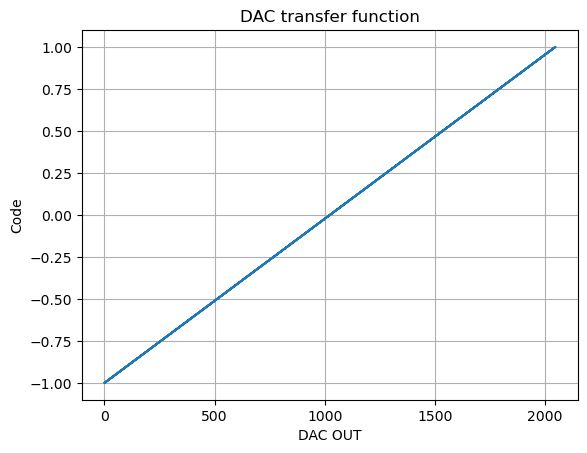

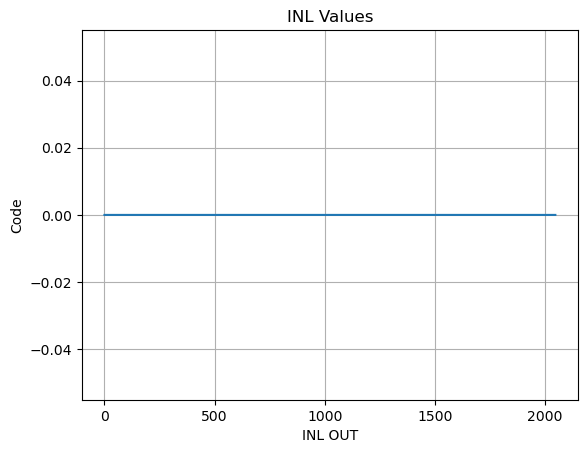

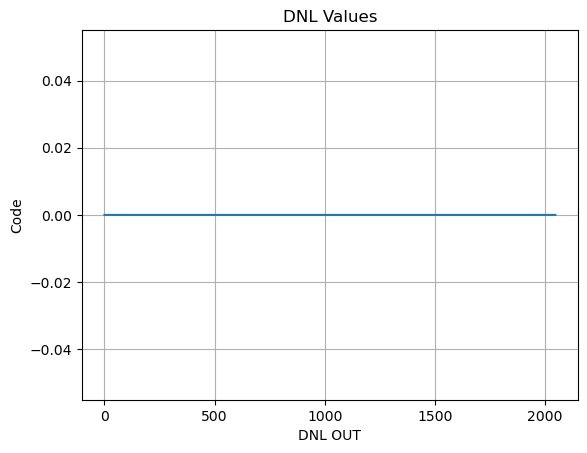

In [4]:
#Ideal values
n_bits  = 11
C_ai    = np.asarray([ 1, 2, 4, 8, 16,32])
C_bi    = np.asarray([ 1, 2, 4, 8, 16,32])
C_Li    = np.asarray([ 1, 2, 4, 8 ])
C_M0    = 1
C_B     = (2**(len(C_Li)))/( (2**(len(C_Li))) - 1 )
C_B0l   = 1
vr      = 1
Voffset = 0 

weights = dac_bit_weight(
            vr,
            C_ai,
            C_bi,
            C_M0, 
            C_Li,
            C_B,
            C_B0l,
            n_bits=n_bits
) 
print(weights)
res_dac = np.zeros(shape=(2**n_bits),dtype=TYPE)
for j in range(0,2**n_bits ):
    code = num2bin(j,n_bits)
    i = 0
    for b in code:
        res_dac[j] += weights[i][b] - weights[i][(b-1)*(-1)]
        i += 1

Vlsb_real = get_Vlsb_real(res_dac)
print(Vlsb_real)
inl_res = get_INL(res_dac, Vlsb_real)

dnl_res = get_DNL(res_dac, Vlsb_real)

#Plots
x = [ n for n in range(0,2**n_bits) ]
plt.step(x, res_dac,where='mid')
#plt.plot(x, res_dac, 'o', color='orange')
plt.xlabel("DAC OUT")
plt.ylabel("Code")
plt.title("DAC transfer function")
#  plt.legend()
plt.grid(True)
plt.show()

plt.step(x, inl_res,where='mid')
#plt.plot(x, res_dac, 'o', color='orange')
plt.xlabel("INL OUT")
plt.ylabel("Code")
plt.title("INL Values")
plt.grid(True)
plt.show()

plt.step(x[:-1], dnl_res,where='mid')
#plt.plot(x, res_dac, 'o', color='orange')
plt.xlabel("DNL OUT")
plt.ylabel("Code")
plt.title("DNL Values")
plt.grid(True)
plt.show()

## ADC

In [5]:
code_vec  = np.asarray([ 2**i for i in range( 0,n_bits+1 ) ])
bit_masks = np.array([1 << i for i in range(n_bits+1)], dtype=np.int64)

def code2num(code) -> int:
    return np.sum(code*code_vec)

@njit(nopython=True,fastmath=True)
def adc(vin,dac_weights_plus,dac_weights_minus,n_bits_dac,Voffset=0) -> list[int]:

    ind   = n_bits_dac  
    b_aux = vin > 0
    res = bit_masks[n_bits_dac]*b_aux

    for i in range(n_bits_dac-1,-1,-1):
        
        vin  += dac_weights_plus[i][np.uint8(not(b_aux))] - dac_weights_minus[i][np.uint8(b_aux)]
        b_aux =  vin > Voffset
        ind  -= 1
        res  += bit_masks[i]*b_aux
        
    return res

def adc_evo( vin,dac_weights_plus,dac_weights_minus,n_bits_dac,Voffset=0 ):

    vip   = vin/2 +1
    vin   = -vin/2 +1
    ind   = n_bits_dac  
    b_aux = vip > vin
    res   = bit_masks[n_bits_dac]*b_aux

    vip_arr = [ float() for _ in range(n_bits+1) ]
    vin_arr = [ float() for _ in range(n_bits+1) ]

    vip_arr[0] = vip
    vin_arr[0] = vin

    j = 1
    for  i in range(n_bits_dac-1,-1,-1):
        vip   += dac_weights_plus[i][np.uint8(not(b_aux))]
        vin   += dac_weights_minus[i][np.uint8(b_aux)]
        vip_arr[j] = vip
        vin_arr[j] = vin
        j     += 1
        b_aux  = vip + Voffset > vin        
        ind   -= 1
        res   += bit_masks[i]*b_aux

    return vip_arr,vin_arr

@njit(parallel=True, fastmath=True)
def adc_tf(num_points,n_bits_dac,Vr,dac_weights_plus,dac_weights_minus,Voffset=0):

    step = TYPE(Vr)/TYPE(num_points)
    vin  = np.linspace(-Vr/2 - 0.05, Vr/2 + 0.05- step, num_points)
    return [ adc(v,dac_weights_plus,dac_weights_minus, n_bits_dac,Voffset) for v in vin ] , vin

#@njit(parallel = True,nopython=True)
def get_trans(vin,tf_all,n_bits):

    code_tran = np.empty((2 << (n_bits-1)), dtype=np.uint16) 
    vin_tran  = np.empty((2 << (n_bits-1)), dtype=TYPE) 
    
    j = 0
    prev = tf_all[0]
    for i in range(1, len(tf_all)):
        curr = tf_all[i]
        if curr != prev:
            vin_tran[j]  = vin[i]
            code_tran[j] = curr
            j += 1
        prev = curr
    # Slice to actual number of transitions
    return vin_tran[:j],code_tran[:j]

def adc_lsb(vin):
    return (vin[len(vin)-1]- vin[0])/( len(vin)-1)

def adc_inl(vin,vlsbreal):
    size    = len(vin)
    inl     = np.empty( size,dtype=TYPE )
    maxInl  = 0
    minInl  = float('inf')
    for i in range(size):
        #print("Vin = "+str(vin[i]-vin[1]))
        #print("VinIdeal = "+str((i-1)*vlsbreal))
        #print(vin[i]-vin[1]-(i-1)*vlsbreal)
        inl_aux = ( vin[i]-vin[0] -(i)*vlsbreal )/vlsbreal
        inl[i]  = inl_aux

        if inl_aux > maxInl:
            maxInl = inl_aux

        if inl_aux < minInl:
            minInl = inl_aux
    return inl,minInl,maxInl

def adc_dnl(vin,vlsreal):
    
    size = len(vin) - 1
    dnl = [ float() for _ in range(size) ]
    maxDnl  = 0
    minDnl  = float('inf')
    for i in range(size):
        dnl_aux = ((vin[i+1]-vin[i])/vlsreal) - 1
        dnl[i] = dnl_aux
        if dnl_aux > maxDnl:
            maxDnl = dnl_aux

        if dnl_aux < minDnl:
            minDnl = dnl_aux
   
    return dnl,minDnl,maxDnl

def adc_lin(max_er,min_er,n_bits):
    return n_bits-np.log2( max_er- min_er )


/usr/lib/python3.13/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


### ADC Test

In [6]:
tf_all,vin = adc_tf(10000*2**n_bits,n_bits,vr*2,weights,weights)
vin_trans,code_trans = get_trans(vin,tf_all,n_bits+1)

vlsbreal = adc_lsb(vin_trans)
vlsbideal = 2/(2**(n_bits+1))

step = 2 / (1000 * 2**(n_bits+1))
x = np.arange(-1.05, 1.05, step)

inl,min_inl,max_inl = adc_inl(vin_trans,vlsbreal)
dnl,min_dnl,max_dnl = adc_dnl(vin_trans,vlsbreal)

lin_inl = adc_lin(max_inl,min_inl,n_bits+1)
lin_dnl = adc_lin(max_dnl,min_dnl,n_bits+1)

vip_arr,vin_arr = adc_evo(0.69,weights,weights,n_bits)


## Outputs

VLSB Real             = 0.0004882812737961566
Erro Vlsb             =  4.8734528634852836e-08
Erro linearidade(inl) =  23.3293978922568
Erro linearidade(dnl) =  24.217323117798596


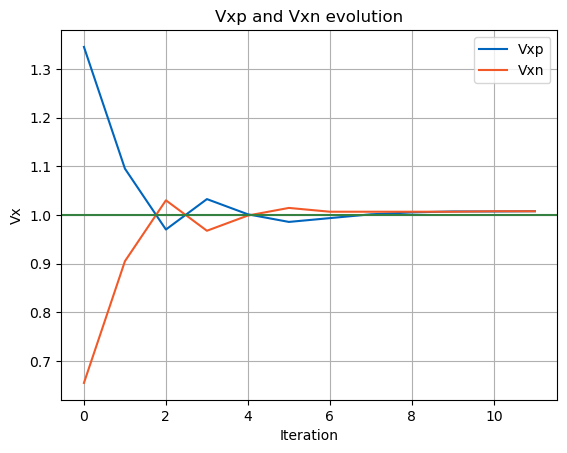

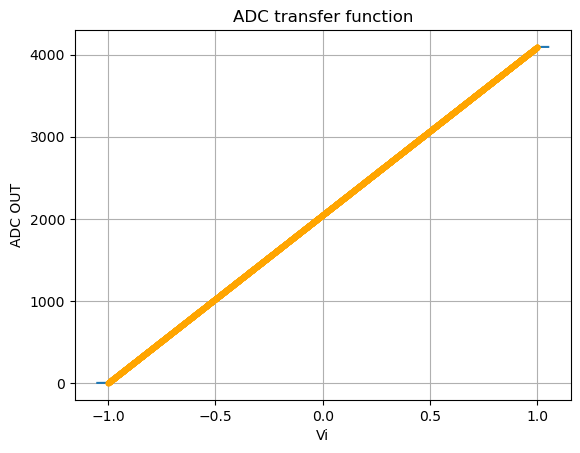

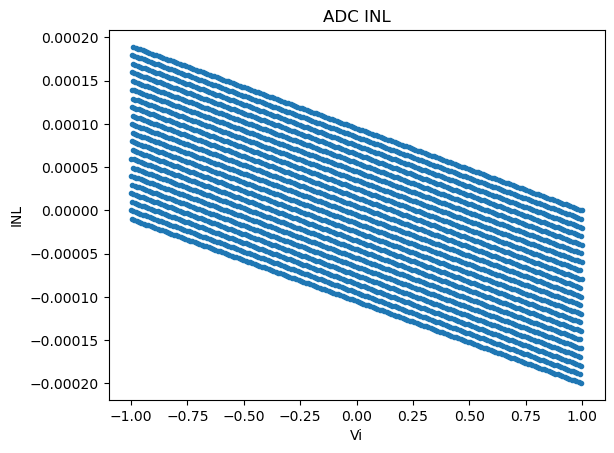

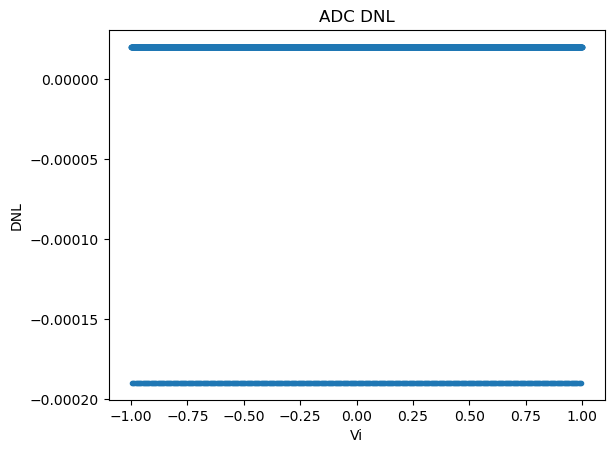

In [7]:
print( "VLSB Real             = " +str( vlsbreal ))
print( "Erro Vlsb             = ", (vlsbreal - vlsbideal)/vlsbideal )
print( "Erro linearidade(inl) = ", lin_inl)
print( "Erro linearidade(dnl) = ", lin_dnl)

plt.plot([i for i in range(n_bits+1)],vip_arr,label="Vxp",color=Blue)
plt.plot([i for i in range(n_bits+1)],vin_arr,label="Vxn",color=Orange)
plt.axhline(y=1,color=Green)
plt.ylabel("Vx")
plt.xlabel("Iteration")
plt.title("Vxp and Vxn evolution")
plt.legend()
plt.grid(True)
plt.show()


plt.step(vin,tf_all,where='mid')
plt.step(vin_trans, code_trans, '.', color='orange')
plt.ylabel("ADC OUT")
plt.xlabel("Vi")
plt.title("ADC transfer function")
#  plt.legend()
plt.grid(True)
plt.show()

plt.step(vin_trans,inl,'.',label="INL")
plt.ylabel("INL")
plt.xlabel("Vi")
plt.title("ADC INL")
plt.show()

plt.step(vin_trans[:-1],dnl,'.',label="DNL")
plt.ylabel("DNL")
plt.xlabel("Vi")
plt.title("ADC DNL")
plt.show()


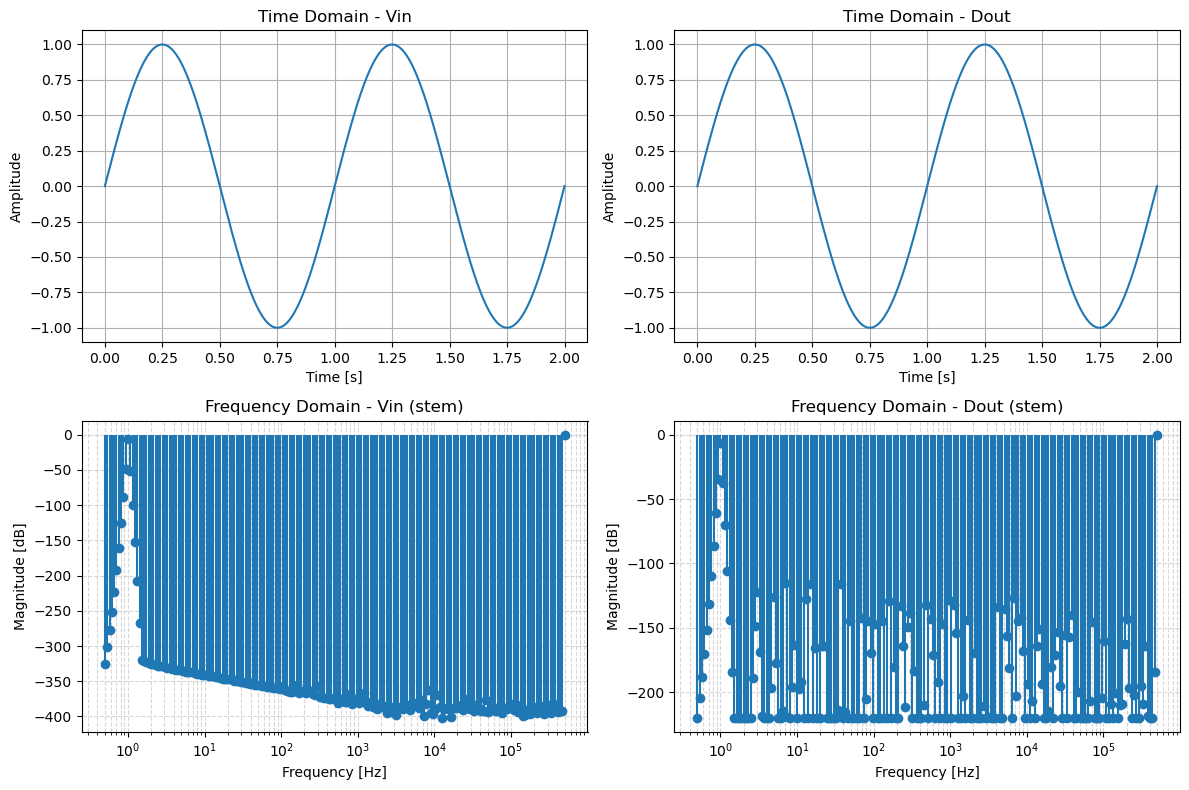

In [ ]:
from scipy.interpolate import interp1d

fs = 10e5  
T = 2.0    
f0 = 1.0   

t = np.linspace(0, T, int(fs*T), endpoint=False)

vin = np.sin(2 * np.pi * f0 * t)

Dout = np.asarray([ adc(v,weights,weights,n_bits,Voffset=0)*vlsbreal - vr for v in vin ])

# Compute FFT
N = len(vin)
freq = np.fft.fftfreq(N, 1/fs)
mask = freq > 0
freq = freq[mask]

VIN = np.fft.fft(vin)
DOUT = np.fft.fft(Dout)

VIN_mag = 20*np.log10(np.abs(VIN[mask]) / N)
DOUT_mag = 20*np.log10(10e-12+np.abs(DOUT[mask]) / N)

f_min = freq[0]
f_max = fs / 2
num_bins = 200
log_freqs = np.logspace(np.log10(f_min), np.log10(f_max), num_bins)

VIN_interp  = interp1d(freq, VIN_mag, kind='linear', bounds_error=False, fill_value=0.0)
DOUT_interp = interp1d(freq, DOUT_mag, kind='linear', bounds_error=False, fill_value=0.0)
VIN_log     = VIN_interp(log_freqs)
DOUT_log    = DOUT_interp(log_freqs)

# Plot in 2x2 subfigures
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Time-domain plots
axs[0, 0].plot(t, vin)
axs[0, 0].set_title('Time Domain - Vin')
axs[0, 0].set_xlabel('Time [s]')
axs[0, 0].set_ylabel('Amplitude')
axs[0, 0].grid(True)

axs[0, 1].plot(t, Dout)
axs[0, 1].set_title('Time Domain - Dout')
axs[0, 1].set_xlabel('Time [s]')
axs[0, 1].set_ylabel('Amplitude')
axs[0, 1].grid(True)

# Frequency-domain plots
axs[1, 0].semilogx(log_freqs[:-1], VIN_log[:-1],'.')
axs[1, 0].set_title('Frequency Domain - Vin')
axs[1, 0].set_xlabel('Frequency [Hz]')
axs[1, 0].set_ylabel('Magnitude')
axs[1, 0].grid(True)

axs[1, 1].semilogx(log_freqs[:-1], DOUT_log[:-1],'.')
axs[1, 1].set_title('Frequency Domain - Dout')
axs[1, 1].set_xlabel('Frequency [Hz]')
axs[1, 1].set_ylabel('Magnitude')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


# Monte Carlo

In [ ]:
import sys
import time  # only for demo purposes
bar_length = 40  # adjust to make the bar longer or shorter
#Ideal values
n_bits  = 11
C_ai    = np.asarray([ 1, 2, 4, 8, 16,32])
C_bi    = np.asarray([ 1, 2, 4, 8, 16,32])
C_Li    = np.asarray([ 1, 2, 4, 8 ])
C_M0    = 1
C_B     = (2**(len(C_Li)))/( (2**(len(C_Li))) - 1 )
C_B0l   = 1
vr      = 1
Voffset = 0 

def gen_components(s_cap,n_sim):
    # For vector caps: shape = (M, N)
    mc_C_ai = np.random.normal(loc=C_ai,  scale=s_cap, size=(n_sim, C_ai.size))
    mc_C_bi = np.random.normal(loc=C_bi,  scale=s_cap, size=(n_sim, C_bi.size))
    mc_C_Li = np.random.normal(loc=C_Li,  scale=s_cap, size=(n_sim, C_Li.size))

    # For scalars, just draw M samples
    mc_C_M0  = np.random.normal(loc=C_M0 , scale=s_cap, size=n_sim)
    mc_C_B   = np.random.normal(loc=C_B  , scale=s_cap, size=n_sim)
    mc_C_B0l = np.random.normal(loc=C_B0l, scale=s_cap, size=n_sim)
    
    #TODO Vr e Voffset e CB

    return mc_C_B,mc_C_ai, mc_C_bi, mc_C_Li, mc_C_M0, mc_C_B0l

def monte_carlo(s_cap,s_offset,n_sim):

    mc_C_B_p,mc_C_ai_p, mc_C_bi_p, mc_C_Li_p, mc_C_M0_p, mc_C_B0l_p = gen_components(s_cap,n_sim)
    mc_C_B_n,mc_C_ai_n, mc_C_bi_n, mc_C_Li_n, mc_C_M0_n, mc_C_B0l_n = gen_components(s_cap,n_sim)
    Vr          = vr
    Voffset = 0#Voffset     = np.random.normal(loc=0 , scale=s_offset, size=n_sim)
    n_bits_dac  = C_ai.size + C_Li.size + 1
    n_bits_adc  = n_bits_dac + 1

    num_points  = 100*2**(n_bits+1)

    res_arr  = np.empty(shape=n_sim,dtype=object)
    vlsb_arr = np.empty(shape=n_sim,dtype=TYPE)
    lin_arr  = np.empty(shape=n_sim,dtype=TYPE)
    inl_arr  = np.empty(shape=n_sim,dtype=object)
    dnl_arr  = np.empty(shape=n_sim,dtype=object)

    for i in range(n_sim):

        weights_plus =  dac_bit_weight(#TODO nao esquecer de indexar cb e vr
            Vr,
            mc_C_ai_p[i], mc_C_bi_p[i],
            mc_C_M0_p[i],mc_C_Li_p[i],
            mc_C_B_p[i], mc_C_B0l_p[i],
            n_bits
            )
        weights_minus =  dac_bit_weight(#TODO nao esquecer de indexar cb e vr
            Vr,
            mc_C_ai_n[i], mc_C_bi_n[i],
            mc_C_M0_n[i],mc_C_Li_n[i],
            mc_C_B_n[i], mc_C_B0l_n[i],
            n_bits
            )
        
        tf_all, vin = adc_tf(
            num_points,n_bits_dac,Vr*2,
            weights_plus,weights_minus,
            Voffset
            )
        tf_aux      = get_trans(vin,tf_all,n_bits_adc)
        res_arr[i]  = tf_aux  
        vlsbaux     = adc_lsb(tf_aux[0])
        vlsb_arr[i] = vlsbaux

        dnl_arr[i],_,_           = adc_dnl(tf_aux[0],vlsbaux)
        inl_aux,min_inl,max_inl  = adc_inl(tf_aux[0],vlsbaux)
        inl_arr[i]  = inl_aux
        lin_arr[i]  = adc_lin(max_inl,min_inl,n_bits+1)
        
        progress = (i + 1) / n_sim
        filled = int(bar_length * progress)
        bar = '=' * filled + '-' * (bar_length - filled)
        percent = progress * 100

        # \r returns cursor to start of line; end='' avoids newline
        sys.stdout.write(f'\rProgress: [{bar}] {percent:6.2f}%')
        sys.stdout.flush()

    return res_arr,vlsb_arr,inl_arr,dnl_arr,lin_arr

nsim = 10000
res,vlsb_arr,inl_arr,dnl_arr,lin_arr = monte_carlo(0.05,0.05,nsim)

#
#minVlsb = min( vlsb_arr )
#maxVlsb = max( vlsb_arr )
#
#vlsb_arr.sort()
#
#vlsb_val_arr = np.linspace(minVlsb, maxVlsb, 100)
#n_val_arr    = np.zeros(100, dtype=int)
#
#i = 0
#for j in range(len(vlsb_val_arr)):
#
#    while vlsb_val_arr[j] > vlsb_arr[i]:
#        i += 1
#        n_val_arr[j] += 1



Progress: [========================================] 100.00%

Minimum value for Lsb =  0.0004882628202978424
Maximum value for Lsb =  0.0005684008832058434

Minimum value for Linearity =  7.572270259216853
Maximum value for Linearity =  11.351154186348506


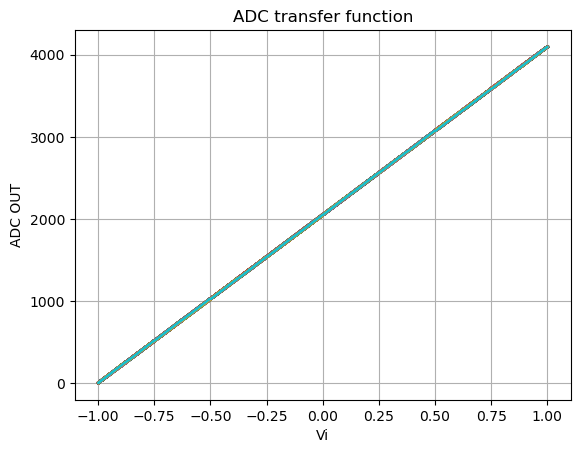

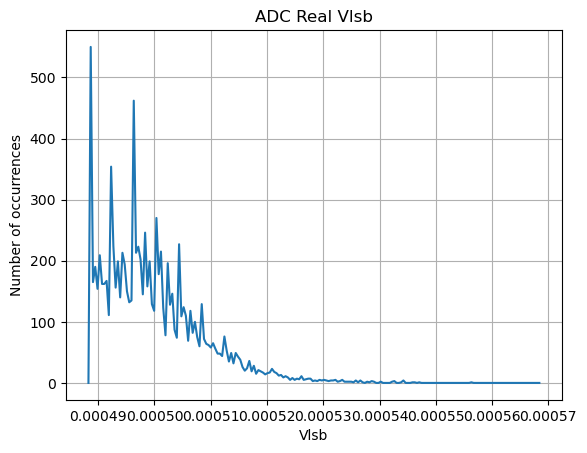

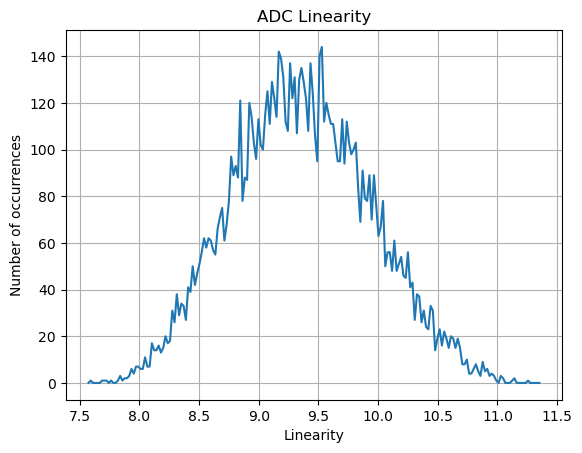

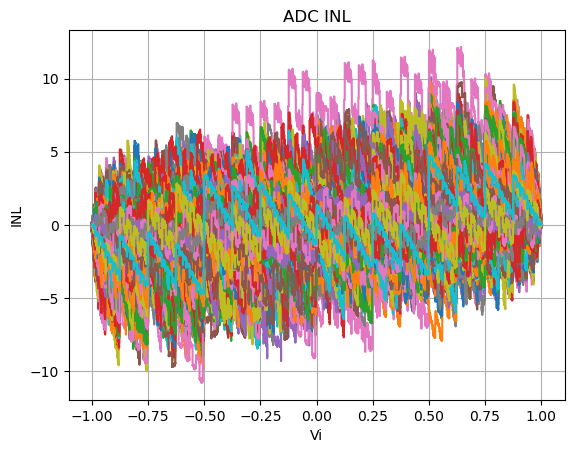

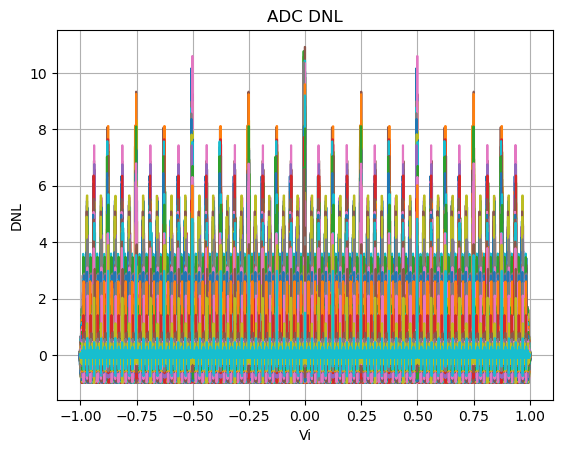

In [ ]:
#Make distribuition array
vlsb_arr.sort()

minVlsb = min( vlsb_arr )
maxVlsb = max( vlsb_arr )

vlsb_val_arr = np.linspace(minVlsb, maxVlsb, 200)
n_val_arr    = np.zeros(200, dtype=int)

i = 0
for j in range(len(vlsb_val_arr)):

    while vlsb_val_arr[j] > vlsb_arr[i]:
        i += 1
        n_val_arr[j] += 1

lin_arr.sort()

minLin = min(lin_arr)
maxLin = max(lin_arr)

lin_val_arr = np.linspace(minLin, maxLin, 200)
n_lin_arr    = np.zeros(200, dtype=int)

i = 0
for j in range(len(lin_val_arr)):

    while lin_val_arr[j] > lin_arr[i]:
        i += 1
        n_lin_arr[j] += 1

print("Minimum value for Lsb = ",minVlsb)
print("Maximum value for Lsb = ",maxVlsb)
print()
print("Minimum value for Linearity = ",minLin)
print("Maximum value for Linearity = ",maxLin)


#Plot ADC dout
for i in range(nsim):

    plt.step(res[i][0],res[i][1],where='pre')
    plt.ylabel("ADC OUT")
    plt.xlabel("Vi")
    plt.title("ADC transfer function")
    #  plt.legend()
plt.grid(True)
plt.show()

#plt.step([i for i in range(nsim) ],vlsb_arr,where='pre')
#plt.ylabel("Vlsb Value")
#plt.xlabel("iteration")
#plt.title("ADC Vlsb")
##  plt.legend()
#plt.grid(True)
#plt.show()

#Plot vlsb distribution 
plt.plot(vlsb_val_arr,n_val_arr)
plt.ylabel("Number of occurrences")
plt.xlabel("Vlsb")
plt.title("ADC Real Vlsb")
#  plt.legend()
plt.grid(True)
plt.show()

#Plot Linearity distribution 
plt.plot(lin_val_arr,n_lin_arr)
plt.ylabel("Number of occurrences")
plt.xlabel("Linearity")
plt.title("ADC Linearity")
#  plt.legend()
plt.grid(True)
plt.show()


#Plot inl
for i in range(nsim):

    plt.step(res[i][0],inl_arr[i],where='pre')
    plt.ylabel("INL")
    plt.xlabel("Vi")
    plt.title("ADC INL")
    #  plt.legend()
plt.grid(True)
plt.show()

#Plot dnl
for i in range(nsim):

    plt.step(res[i][0][:-1],dnl_arr[i],where='pre')
    plt.ylabel("DNL")
    plt.xlabel("Vi")
    plt.title("ADC DNL")
    #  plt.legend()
plt.grid(True)
plt.show()